quick branch to extract col and row in addition to target/non-target

In [25]:
%matplotlib widget
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from IPython.display import display

In [26]:
%load_ext autoreload
%autoreload 2

from help_func import *
from help_fischer import *
from help_ML import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# Load the data
base_path = Path.cwd().parent  / "data"/ "openvibe2csv" 
df_eeg= pd.read_csv(base_path /'rec_test3_mux.csv')

In [28]:
import numpy as np

def parse_event_codes(entry):
    if pd.isna(entry):
        return []
    try:
        # Take first segment before comma, then split by ':'
        codes = str(entry).split(",")[0].split(":")
        return [int(code) for code in codes if code.strip().isdigit()]
    except:
        return []
    

# Parse and filter event codes
def filter_target_nontarget(code_list, valid_markers=None):
    
    if not code_list:  # handles empty lists
        return -1
    for code in code_list:
        if code in valid_markers:
            return code
    return -1


    
    



def extract_and_average_target_nontarget_epochs(df, fs=128, tmin=-0.2, tmax=1.0, 
                                                normalization="A1", 
                                                blink_channel_idx=0, 
                                                blink_threshold=120,
                                                n_average=0):
    """
    Extract and average EEG epochs for target (33285) and non-target (33286) events.

    Parameters
    ----------
    df : pd.DataFrame
        EEG + marker data. Must include time in first column and 'Event Id'.
    fs : int
        Sampling frequency in Hz.
    tmin : float
        Seconds before marker.
    tmax : float
        Seconds after marker.
    normalization : str
        One of 'A1', 'A2', 'A3'.
    blink_channel_idx : int
        Channel index to use for blink rejection (based on peak-to-peak).
    blink_threshold : float
        Reject epochs with peak-to-peak amplitude > threshold.
    n_average : int
        If > 0, limit the number of epochs to average.

    Returns
    -------
    averaged_epochs : dict
        {'target': (epoch_len, n_channels), 'nontarget': (epoch_len, n_channels)}
    """
    time_col = df.columns[0]
    event_col = 'Event Id'
    eeg_cols = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

    timestamps = df[time_col].values
    events_raw = df[event_col].values
    eeg_data = df[eeg_cols].values

    #events = np.array([int(e) if not pd.isna(e) else -1 for e in events_raw])

    events = [parse_event_codes(e) for e in events_raw]
    print(events)
    events_target = np.array([filter_target_nontarget(e,valid_markers = {33285, 33286}) for e in events])
    print(events_target)
    events_row_col = np.array([filter_target_nontarget(e,valid_markers = {33025, 33026, 33027, 33031, 33032, 33033}) for e in events])
    print(events_row_col)





    pre_samples = int(abs(tmin) * fs)
    post_samples = int(tmax * fs)
    epoch_len = pre_samples + post_samples
    epoch_offsets = np.arange(-pre_samples, post_samples)[None, :]

    out = {}
    for label_name, marker_id in [('target', 33285), ('nontarget', 33286)]:
        idxs = np.where(events_target == marker_id)[0]

        if len(idxs) == 0:
            out[label_name] = np.full((epoch_len, eeg_data.shape[1]), np.nan)
            continue

        if n_average > 0:
            idxs = idxs[:n_average]

        valid = (idxs - pre_samples >= 0) & (idxs + post_samples < len(df))
        idxs = idxs[valid]

        if len(idxs) == 0:
            out[label_name] = np.full((epoch_len, eeg_data.shape[1]), np.nan)
            continue

        epochs = np.stack([eeg_data[i + epoch_offsets[0]] for i in idxs], axis=0)  # (n_epochs, epoch_len, n_channels)

        # Blink rejection (vectorized)
        blink_channel = epochs[:, :, blink_channel_idx]
        ptp = np.ptp(blink_channel, axis=1)
        keep_mask = ptp <= blink_threshold
        epochs = epochs[keep_mask]

        if normalization == "A1":
            epochs_demeaned = epochs - epochs.mean(axis=1, keepdims=True)
            averaged = epochs_demeaned.mean(axis=0)

        elif normalization == "A2":
            averaged = epochs.mean(axis=0)
            averaged = averaged - averaged.mean(axis=0, keepdims=True)

        elif normalization == "A3":
            averaged = epochs.mean(axis=0)

        else:
            raise ValueError("Invalid normalization. Use 'A1', 'A2', or 'A3'.")

        out[label_name] = averaged

    return out, events_target, events_row_col


In [29]:
out, events_target, events_row_col  = extract_and_average_target_nontarget_epochs(df_eeg, fs=128, tmin=-0.2, tmax=1.0)


[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [],

In [30]:
print(events_target)

[-1 -1 -1 ... -1 -1 -1]


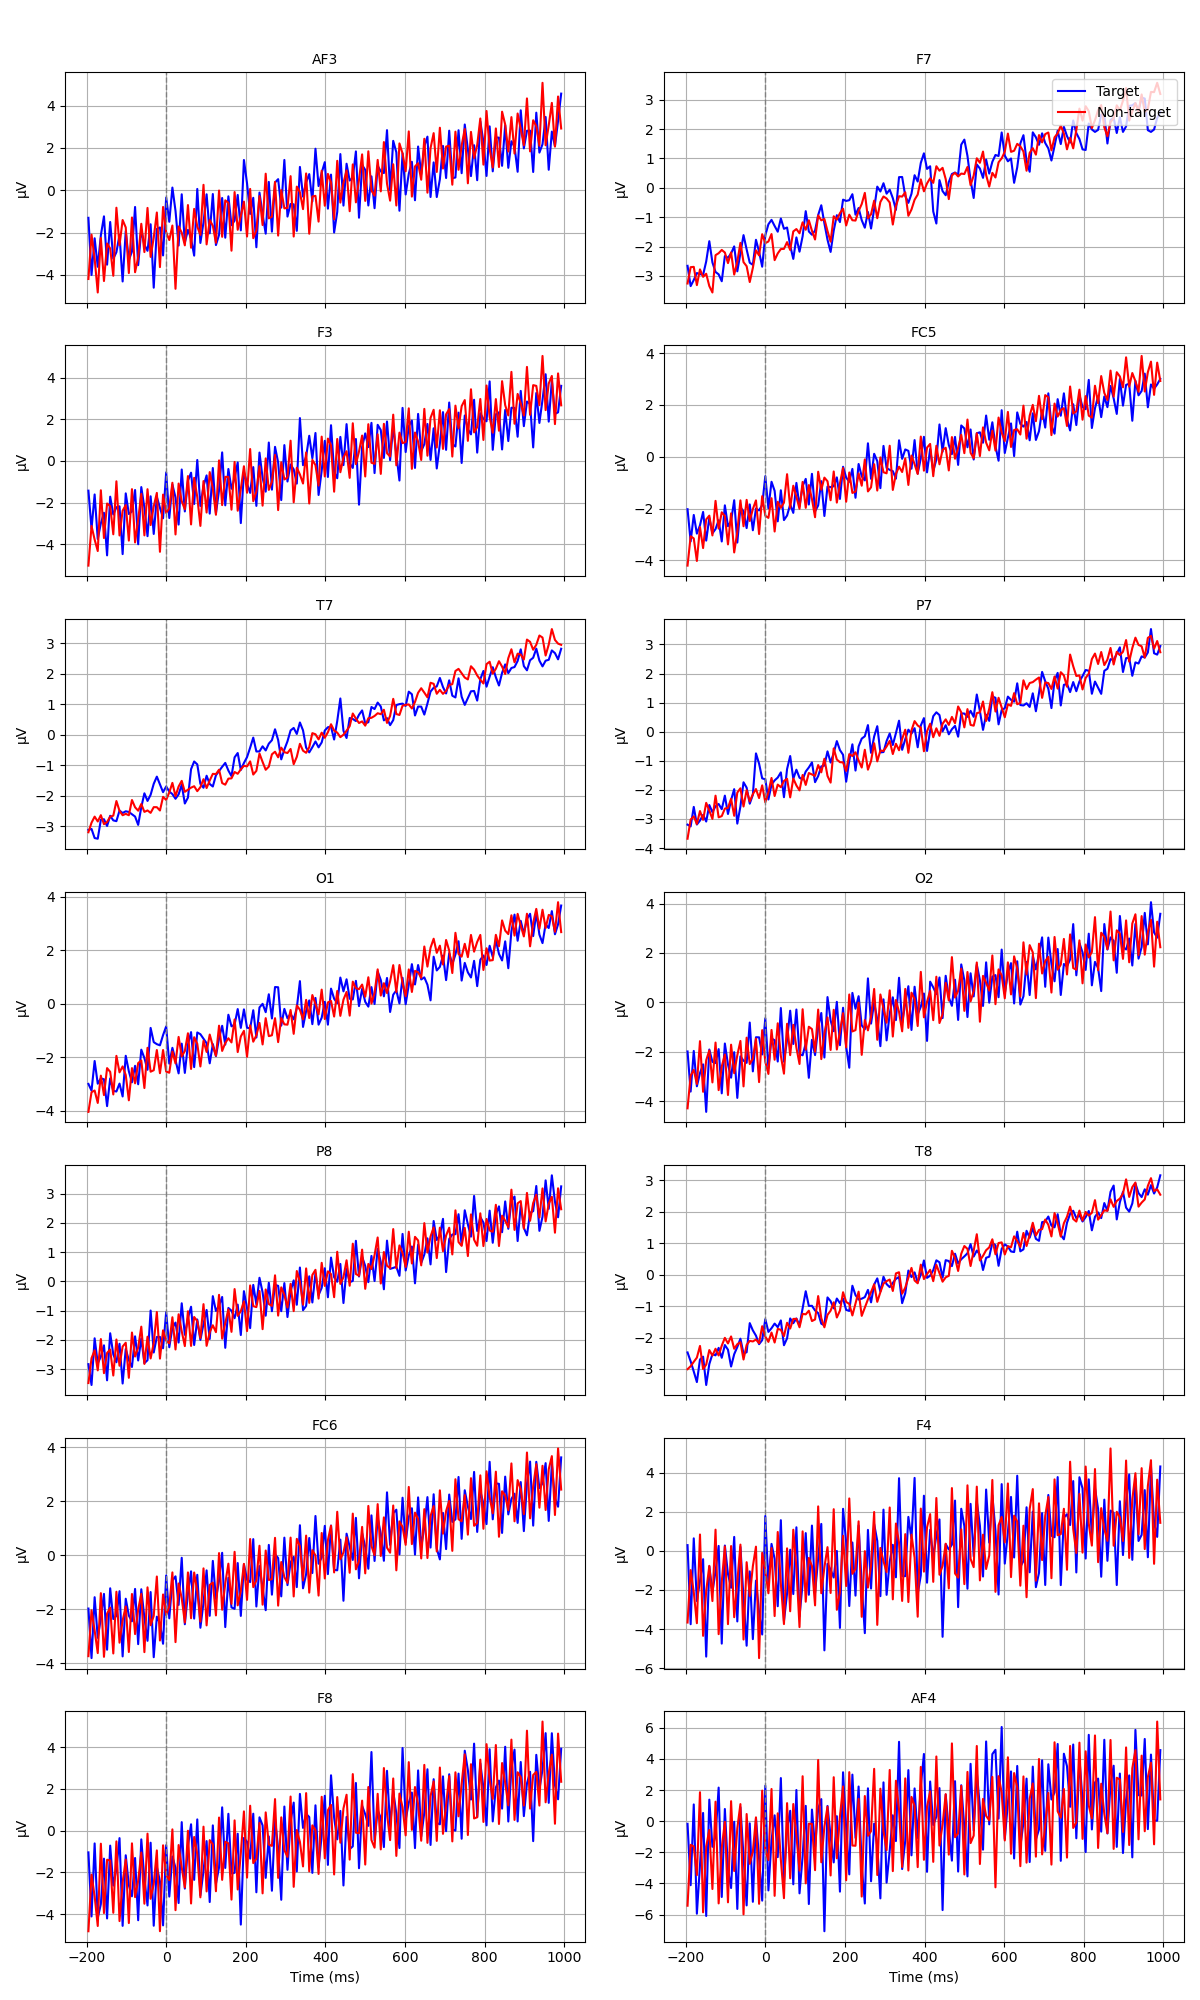

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Extract from dict
mean_target = out['target']
mean_nontarget = out['nontarget']

# Channel labels in OpenViBE order
channel_names = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", 
                 "P8", "T8", "FC6", "F4", "F8", "AF4"]

# Time axis in milliseconds
epoch_len = mean_target.shape[0]
fs = 128  # or whatever sampling rate you used
time_vector = (np.arange(epoch_len) - int(0.2 * fs)) / fs * 1000  # center at 0 ms

# 7x2 subplot grid
fig, axes = plt.subplots(7, 2, figsize=(12, 20), sharex=True)

for i, ax in enumerate(axes.flat):
    if i >= len(channel_names):
        ax.axis('off')
        continue
    ax.plot(time_vector, mean_target[:, i], label='Target', color='blue')
    ax.plot(time_vector, mean_nontarget[:, i], label='Non-target', color='red')
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_title(f"{channel_names[i]}", fontsize=10)
    ax.set_ylabel("µV")
    ax.grid(True)

# Label bottom axes
axes[-1, 0].set_xlabel("Time (ms)")
axes[-1, 1].set_xlabel("Time (ms)")
axes[0, 1].legend(loc='upper right')

plt.suptitle(f"Target vs Non-target Averaged ERPs ({fs} Hz)", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig("erp_target_vs_nontarget.png", dpi=300)
plt.show()


In [32]:
print(df_eeg.columns.tolist())


['Time:128Hz', 'Epoch', 'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'Event Id', 'Event Date', 'Event Duration']
